[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ravichandra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Naive Bayes...
Naive Bayes Log Loss: 1.1700
Training K-Nearest Neighbors...
KNN Log Loss: 1.0726
Training Logistic Regression...
Logistic Regression Log Loss: 0.9549
Training Linear-SVM...
Linear SVM Log Loss: 1.0292
Training Random Forest...
Random Forest Log Loss: 0.9708


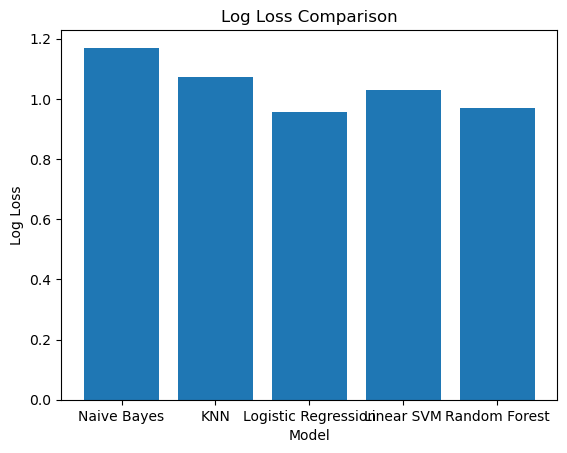

In [2]:
import pandas as pd
import numpy as np
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load data
train_variants = pd.read_csv('training_variants')
train_text = pd.read_csv('training_text', sep='\\|\\|', engine='python', names=['ID', 'TEXT'], skiprows=1)

# Preprocess text data
def nlp_preprocessing(text):
    if isinstance(text, str):
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text).lower()  # Remove special characters and lowercase
        text = re.sub('\s+', ' ', text)  # Remove extra spaces
        return ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return ""

train_text['TEXT'] = train_text['TEXT'].apply(nlp_preprocessing)

# Merge the two datasets on 'ID'
data = pd.merge(train_variants, train_text, on='ID', how='left')
y = data['Class'].values  # Target variable

# One-hot encode 'Gene' and 'Variation' columns
ohe_gene = OneHotEncoder(handle_unknown='ignore')
ohe_variation = OneHotEncoder(handle_unknown='ignore')

gene_ohe = ohe_gene.fit_transform(data[['Gene']])
variation_ohe = ohe_variation.fit_transform(data[['Variation']])

# Apply TF-IDF vectorization on the text data
tfidf = TfidfVectorizer(min_df=3, max_features=5000)
text_tfidf = tfidf.fit_transform(data['TEXT'])

# Combine all features (Gene, Variation, Text)
X = hstack([gene_ohe, variation_ohe, text_tfidf])

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

# Baseline Model - Naive Bayes
print("Training Naive Bayes...")
nb_clf = MultinomialNB(alpha=1e-05)
nb_clf.fit(X_train, y_train)
calib_nb = CalibratedClassifierCV(nb_clf, method='sigmoid')
calib_nb.fit(X_train, y_train)
y_pred_nb = calib_nb.predict_proba(X_cv)
print(f"Naive Bayes Log Loss: {log_loss(y_cv, y_pred_nb):.4f}")

# K-Nearest Neighbors Classification
print("Training K-Nearest Neighbors...")
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X_train, y_train)
calib_knn = CalibratedClassifierCV(knn_clf, method='sigmoid')
calib_knn.fit(X_train, y_train)
y_pred_knn = calib_knn.predict_proba(X_cv)
print(f"KNN Log Loss: {log_loss(y_cv, y_pred_knn):.4f}")

# Training Logistic Regression
print("Training Logistic Regression...")
log_reg_clf = SGDClassifier(loss='log_loss', alpha=1e-05, class_weight='balanced', random_state=42)
log_reg_clf.fit(X_train, y_train)
calib_log_reg = CalibratedClassifierCV(log_reg_clf, method='sigmoid')
calib_log_reg.fit(X_train, y_train)
y_pred_log_reg = calib_log_reg.predict_proba(X_cv)
log_loss_log_reg = log_loss(y_cv, y_pred_log_reg)
print(f"Logistic Regression Log Loss: {log_loss_log_reg:.4f}")

# Linear-SVM (SGDClassifier with hinge loss)
print("Training Linear-SVM...")
svm_clf = SGDClassifier(loss='hinge', alpha=1e-05, class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)
calib_svm = CalibratedClassifierCV(svm_clf, method='sigmoid')
calib_svm.fit(X_train, y_train)
y_pred_svm = calib_svm.predict_proba(X_cv)
print(f"Linear SVM Log Loss: {log_loss(y_cv, y_pred_svm):.4f}")

# Random Forest
print("Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)
calib_rf = CalibratedClassifierCV(rf_clf, method='isotonic')
calib_rf.fit(X_train, y_train)
y_pred_rf = calib_rf.predict_proba(X_cv)
print(f"Random Forest Log Loss: {log_loss(y_cv, y_pred_rf):.4f}")

# Plot results
log_losses = {
    "Naive Bayes": log_loss(y_cv, y_pred_nb),
    "KNN": log_loss(y_cv, y_pred_knn),
    "Logistic Regression": log_loss(y_cv, y_pred_log_reg),
    "Linear SVM": log_loss(y_cv, y_pred_svm),
    "Random Forest": log_loss(y_cv, y_pred_rf)
}

plt.bar(log_losses.keys(), log_losses.values())
plt.title('Log Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.show()


In [3]:
print(train_variants)

        ID    Gene             Variation  Class
0        0  FAM58A  Truncating Mutations      1
1        1     CBL                 W802*      2
2        2     CBL                 Q249E      2
3        3     CBL                 N454D      3
4        4     CBL                 L399V      4
...    ...     ...                   ...    ...
3316  3316   RUNX1                 D171N      4
3317  3317   RUNX1                 A122*      1
3318  3318   RUNX1               Fusions      1
3319  3319   RUNX1                  R80C      4
3320  3320   RUNX1                  K83E      4

[3321 rows x 4 columns]


In [11]:
df = pd.read_csv("training_text", sep='\\|\\|', engine='python', names=['ID', 'TEXT'], skiprows = 1)
df

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...


In [13]:
data

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...
3318,3318,RUNX1,Fusions,1,runt related transcription factor 1 gene runx1...
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...


Training Decision Tree...
Decision Tree Log Loss: 1.2856


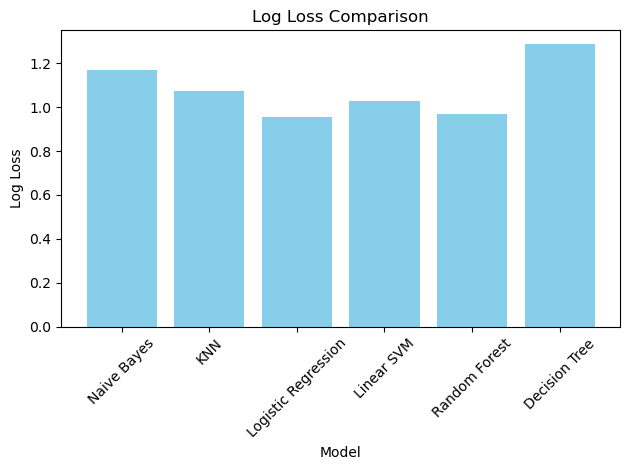

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
print("Training Decision Tree...")
dt_clf = DecisionTreeClassifier(max_depth=100, class_weight='balanced', random_state=42)
dt_clf.fit(X_train, y_train)
calib_dt = CalibratedClassifierCV(dt_clf, method='sigmoid')
calib_dt.fit(X_train, y_train)
y_pred_dt = calib_dt.predict_proba(X_cv)
log_loss_dt = log_loss(y_cv, y_pred_dt)
print(f"Decision Tree Log Loss: {log_loss_dt:.4f}")

# Update the log losses dictionary for visualization
log_losses["Decision Tree"] = log_loss_dt

# Plot results with the new model included
plt.bar(log_losses.keys(), log_losses.values(), color='skyblue')
plt.title('Log Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
